In [126]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

In [127]:
data = pd.read_csv("order_data.csv")
data.head()

,Date,TimeOfDay,MenuItem,Quantity
0,2023-01-01,07:00,Chicken Tikka Masala,2
1,2023-01-01,07:00,Shrimp Scampi,2
2,2023-01-01,07:00,Chicken Alfredo,3
3,2023-01-01,07:00,Caesar Salad,1
4,2023-01-01,07:00,Tiramisu,3


In [128]:
def extract_hour(timestamp):
    time_obj = datetime.strptime(timestamp, '%H:%M')
    return time_obj.hour

# Applying the function to the 'TimeofDay' column to extract hours
data['TimeOfDay'] = data['TimeOfDay'].apply(extract_hour)

In [129]:
# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

In [130]:
# Convert 'Date' column to numeric representation
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['NumericDate'] = (data['Date'] - start_date).dt.days + 1

In [131]:
data = data.groupby(['DateTime', 'Date', 'NumericDate', 'TimeOfDay', 'MenuItem']).agg({'Quantity': 'sum'}).reset_index()
data.head(5)

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,Beef Stroganoff,5
1,2023-01-01 07:00:00,2023-01-01,1,7,Beef Tacos,4
2,2023-01-01 07:00:00,2023-01-01,1,7,Breakfast Combo,1
3,2023-01-01 07:00:00,2023-01-01,1,7,Caesar Salad,1
4,2023-01-01 07:00:00,2023-01-01,1,7,Chicken Alfredo,3


In [132]:
label_encoders = {}
categorical_columns = ['MenuItem']

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col]) + 1

data.head()

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,1,5
1,2023-01-01 07:00:00,2023-01-01,1,7,2,4
2,2023-01-01 07:00:00,2023-01-01,1,7,3,1
3,2023-01-01 07:00:00,2023-01-01,1,7,4,1
4,2023-01-01 07:00:00,2023-01-01,1,7,5,3


In [133]:
# Selecting features and target
X_poly = data[['NumericDate', 'TimeOfDay', 'MenuItem']]
y_poly = data['Quantity']

# Splitting the data into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.4, random_state=42)

# Polynomial features transformation (you can adjust the degree as needed)
poly = PolynomialFeatures(degree=5)
X_train_poly_t = poly.fit_transform(X_train_poly)
X_test_poly_t = poly.transform(X_test_poly)

# Creating and fitting the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly_t, y_train_poly)

# Predicting on the test set
predictions_poly = model_poly.predict(X_test_poly_t)

# Calculating evaluation metrics
mse_poly = mean_squared_error(y_test_poly, predictions_poly)
rmse_poly = np.sqrt(mse_poly)
mae_poly = mean_absolute_error(y_test_poly, predictions_poly)
r_squared_poly = r2_score(y_test_poly, predictions_poly)

print(f"Mean Squared Error (MSE): {mse_poly}")
print(f"Root Mean Squared Error (RMSE): {rmse_poly}")
print(f"Mean Absolute Error (MAE): {mae_poly}")
print(f"R-squared (R²): {r_squared_poly}")


Mean Squared Error (MSE): 37.51703031893388
Root Mean Squared Error (RMSE): 6.12511471883865
Mean Absolute Error (MAE): 4.809340832806286
R-squared (R²): 0.33566808314779006


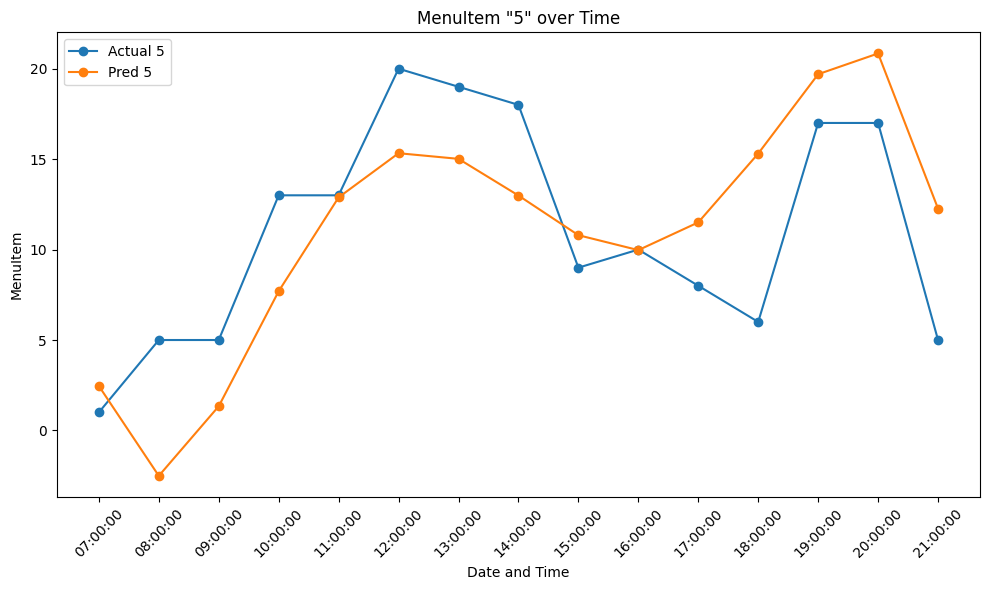

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' contains your dataset with columns NumericDate, TimeOfDay, MenuItem

# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

# Selecting features (including the combined datetime column) and MenuItem
X = data[['DateTime', 'NumericDate', 'TimeOfDay', 'MenuItem', 'Quantity']]

# Filter for a specific date and menu item
selected_date = '2023-01-16'  # Replace with your desired date in 'YYYY-MM-DD' format
selected_menu_item = 5  # Replace with the menu item you want to plot


s_d = X[(X['DateTime'].dt.date == pd.to_datetime(selected_date).date()) & (X['MenuItem'] == selected_menu_item)]
# Selecting features for the specific menu item
X_d = s_d[['NumericDate', 'TimeOfDay', 'MenuItem']]
y_d = s_d['Quantity']

X_d_poly = poly.transform(X_d)
# Predicting for the specific menu item using the already trained model
predictions_d = model_poly.predict(X_d_poly)

selected_data = X[(X['DateTime'].dt.date == pd.to_datetime(selected_date).date()) & (X['MenuItem'] == selected_menu_item)]
plt.figure(figsize=(10, 6))
plt.plot(selected_data['DateTime'].dt.strftime('%H:%M:%S'), selected_data['Quantity'], marker='o', linestyle='-', label="Actual "+str(selected_menu_item))
plt.plot(selected_data['DateTime'].dt.strftime('%H:%M:%S'), predictions_d, marker='o', linestyle='-', label="Pred "+str(selected_menu_item))
plt.xlabel('Date and Time')
plt.ylabel('MenuItem')
plt.title(f'MenuItem "{selected_menu_item}" over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
